Episode 1, Reward: -1068.99
Episode 2, Reward: -1067.23
Episode 3, Reward: -887.46
Episode 4, Reward: -1089.49
Episode 5, Reward: -1514.54
Episode 6, Reward: -1803.26
Episode 7, Reward: -1463.80
Episode 8, Reward: -1658.68
Episode 9, Reward: -1201.46
Episode 10, Reward: -1576.30
Episode 11, Reward: -1137.20
Episode 12, Reward: -1423.58
Episode 13, Reward: -1476.49
Episode 14, Reward: -1374.14
Episode 15, Reward: -1494.34
Episode 16, Reward: -1061.92
Episode 17, Reward: -1300.91
Episode 18, Reward: -1524.35
Episode 19, Reward: -1374.02
Episode 20, Reward: -1471.15
Episode 21, Reward: -1497.99
Episode 22, Reward: -1.91
Episode 23, Reward: -1579.29
Episode 24, Reward: -1398.45
Episode 25, Reward: -547.34
Episode 26, Reward: -137.06
Episode 27, Reward: -265.18
Episode 28, Reward: -133.56
Episode 29, Reward: -2.57
Episode 30, Reward: -264.21
Episode 31, Reward: -132.24
Episode 32, Reward: -371.03
Episode 33, Reward: -239.92
Episode 34, Reward: -2.49
Episode 35, Reward: -133.75
Episode 36, R

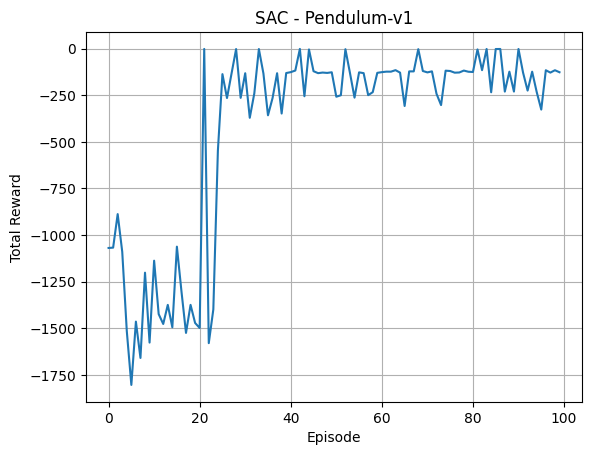

TypeError: size must be two numbers

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal

np.bool8 = np.bool_

# Hyperparameters
env = gym.make("Pendulum-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = float(env.action_space.high[0])
hidden_dim = 128
lr = 3e-4
gamma = 0.99
tau = 0.005
alpha = 0.2  # Entropy coefficient
buffer_capacity = int(1e6)
batch_size = 256
start_steps = 1000

# Replay Buffer
class ReplayBuffer:
    def __init__(self):
        self.buffer = []

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))
        if len(self.buffer) > buffer_capacity:
            self.buffer.pop(0)

    def sample(self):
        batch = np.random.choice(len(self.buffer), batch_size)
        s, a, r, s2, d = zip(*[self.buffer[i] for i in batch])
        return (torch.tensor(s, dtype=torch.float32, device=device),
                torch.tensor(a, dtype=torch.float32, device=device),
                torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
                torch.tensor(s2, dtype=torch.float32, device=device),
                torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1))

# Actor
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(state_dim, hidden_dim), nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = self.net(state)
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        action = torch.tanh(action) * action_bound
        return action, log_prob

# Critic Q-network
def create_critic():
    return nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(),
                         nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                         nn.Linear(hidden_dim, 1))

# Initialize networks
actor = Actor().to(device)
critic1 = create_critic().to(device)
critic2 = create_critic().to(device)
target_critic1 = create_critic().to(device)
target_critic2 = create_critic().to(device)

target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
critic1_opt = optim.Adam(critic1.parameters(), lr=lr)
critic2_opt = optim.Adam(critic2.parameters(), lr=lr)

# Training Loop
buffer = ReplayBuffer()
rewards_per_episode = []
total_steps = 0
max_episodes = 100

for episode in range(max_episodes):
    state, _ = env.reset()
    ep_reward = 0

    for _ in range(200):
        total_steps += 1
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        if total_steps < start_steps:
            action = np.random.uniform(-action_bound, action_bound, action_dim)
        else:
            with torch.no_grad():
                action, _ = actor(state_tensor)
            action = action.cpu().numpy().flatten()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        buffer.push(state, action, reward, next_state, float(done))
        ep_reward += reward
        state = next_state

        if done:
            break

        if len(buffer.buffer) < batch_size:
            continue

        # Sample batch
        s, a, r, s2, d = buffer.sample()

        # Update critics
        with torch.no_grad():
            next_a, next_logp = actor(s2)
            target_q = torch.min(target_critic1(torch.cat([s2, next_a], 1)),
                                 target_critic2(torch.cat([s2, next_a], 1)))
            target = r + gamma * (1 - d) * (target_q - alpha * next_logp)

        q1 = critic1(torch.cat([s, a], 1))
        q2 = critic2(torch.cat([s, a], 1))

        critic1_loss = nn.MSELoss()(q1, target)
        critic2_loss = nn.MSELoss()(q2, target)

        critic1_opt.zero_grad()
        critic1_loss.backward()
        critic1_opt.step()

        critic2_opt.zero_grad()
        critic2_loss.backward()
        critic2_opt.step()

        # Update actor
        new_a, logp = actor(s)
        q1_pi = critic1(torch.cat([s, new_a], 1))
        q2_pi = critic2(torch.cat([s, new_a], 1))
        q_pi = torch.min(q1_pi, q2_pi)

        actor_loss = (alpha * logp - q_pi).mean()

        actor_opt.zero_grad()
        actor_loss.backward()
        actor_opt.step()

        # Soft update target networks
        for target_param, param in zip(target_critic1.parameters(), critic1.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for target_param, param in zip(target_critic2.parameters(), critic2.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    rewards_per_episode.append(ep_reward)
    print(f"Episode {episode+1}, Reward: {ep_reward:.2f}")

# Save models
torch.save(actor.state_dict(), "sac_actor.pth")
torch.save(critic1.state_dict(), "sac_critic1.pth")
torch.save(critic2.state_dict(), "sac_critic2.pth")

# Plot rewards
plt.plot(rewards_per_episode)
plt.title("SAC - Pendulum-v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# # Render final episode
# env = gym.make("Pendulum-v1", render_mode="human")  # Make sure rendering is enabled
# state, _ = env.reset()
# done = False
# while not done:
#     state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
#     with torch.no_grad():
#         action, _ = actor(state_tensor)
#     action = action.cpu().numpy().flatten()
#     state, _, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated
# env.close()

In [15]:
import gym
import torch
import numpy as np
import pygame

# Initialize PyGame
pygame.init()

# Create and load actor network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU()
        )
        self.mean = nn.Linear(128, 1)
        self.log_std = nn.Linear(128, 1)
    
    def forward(self, state):
        x = self.net(state)
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        action = torch.tanh(action) * 2.0
        return action, log_prob

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
actor = Actor().to(device)
actor.load_state_dict(torch.load("sac_actor.pth", map_location=device))
actor.eval()

# Create environment
env = gym.make("Pendulum-v1", render_mode="human")
state, _ = env.reset()
total_reward = 0

for _ in range(200):  # Run for 200 steps max
    # Convert state to tensor
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    
    # Get action from actor
    with torch.no_grad():
        action, _ = actor(state_tensor)
    
    # Process action
    action = action.cpu().numpy().flatten()
    action = np.clip(action, -2.0, 2.0)
    
    # Step environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    state = next_state
    
    # Add small delay for rendering
    pygame.time.delay(20)
    
    # Process events to prevent freezing
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            break
    
    if terminated or truncated:
        break

print(f"Total reward: {total_reward:.2f}")
env.close()
pygame.quit()

TypeError: size must be two numbers